# **Imports**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

In [5]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


# **Data**

In [6]:
mainDIR = os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)')
print(mainDIR)

FileNotFoundError: ignored

In [ ]:
train_folder= '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train'
val_folder = '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val'
test_folder = '/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test'

In [ ]:
# function to calculate viral/bac in a path
def stat_viral_bac(path):
  #stats train pneumonia viral/bacterial
  bac_str ="bacteria"
  cpt_bac = 0
  cpt_vir = 0
  for image_name in os.listdir(path) :
        if bac_str in image_name :
          cpt_bac += 1
        else :
          cpt_vir += 1
  return cpt_bac,cpt_vir 

In [ ]:
# statestics after augmenting the dataset (closing the gap and noise)
# stats train
num_train_normal = len(os.listdir(train_folder+'/Normal'))
num_train_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia'))
TOT_train = num_train_normal + num_train_pneumonia
# stats test
num_test_normal = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Normal'))
num_test_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Pneumonia'))
TOT_test = num_test_pneumonia + num_test_normal
# stats valdidation
num_valid_normal = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Normal'))
num_valid_pneumonia = len(os.listdir('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia'))
TOT_valid = num_valid_normal + num_valid_pneumonia

# stats train viral/bac
num_train_bac,num_train_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia')
# stats test viral/bac
num_test_bac,num_test_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/test/Pneumonia')
# stats validation viral/bac
num_val_bac,num_val_vir = stat_viral_bac('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/val/Pneumonia')

TOT_train_vb = num_train_bac +num_train_vir
TOT_test_vb = num_test_bac + num_test_vir
TOT_valid_vb = num_val_bac + num_val_vir 
#table stat general
t = PrettyTable(['Class','Train','Validation', 'Test'])
t.add_row(['Normal',num_train_normal,num_valid_normal,num_test_normal])
t.add_row(['Pneumonia',num_train_pneumonia,num_valid_pneumonia,num_test_pneumonia])
t.add_row(['Total',TOT_train,TOT_valid,TOT_test])
print(t)

#table Pneumonia
print('\nPneumonia')
t = PrettyTable(['Class','Train','Validation' ,'Test'])
t.add_row(['Pneumonia viral',num_train_vir,num_val_vir,num_test_vir])
t.add_row(['Pneumonia bacterial',num_train_bac,num_val_bac,num_test_bac])
t.add_row(['Total',TOT_train_vb,TOT_valid_vb,TOT_test_vb])
print(t)

+-----------+-------+------------+------+
|   Class   | Train | Validation | Test |
+-----------+-------+------------+------+
|   Normal  |  2659 |    237     | 238  |
| Pneumonia |  3589 |    640     | 642  |
|   Total   |  6248 |    877     | 880  |
+-----------+-------+------------+------+

Pneumonia
+---------------------+-------+------------+------+
|        Class        | Train | Validation | Test |
+---------------------+-------+------------+------+
|   Pneumonia viral   |  1242 |    201     | 236  |
| Pneumonia bacterial |  2347 |    439     | 406  |
|        Total        |  3589 |    640     | 642  |
+---------------------+-------+------------+------+


In [12]:
def claheImage(img): #Nada
    # convert image to LAB color space
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.convertScaleAbs(gray)
    # apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)

    # convert the LAB image back to RGB color space
    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    cl_img = np.float64(final)
    return cl_img

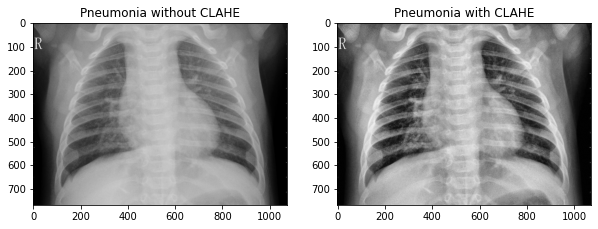

In [ ]:
#plot Pneumonia image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia/person1000_virus_1681.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Pneumonia/person1000_virus_1681.jpeg'))/255)
plt.show()

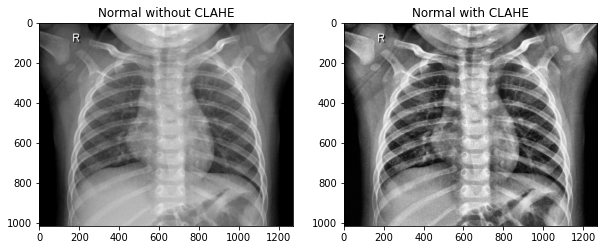

In [ ]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Normal without CLAHE')
plt.imshow(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Normal/IM-0549-0001.jpeg')/255)

fig.add_subplot(rows, columns, 2)
plt.title('Normal with CLAHE')
plt.imshow(claheImage(cv2.imread('/content/drive/MyDrive/Aug (close gap + noise) (splited .7 .15 .15)/train/Normal/IM-0549-0001.jpeg'))/255)
plt.show()

# **Model**

In [ ]:
# data gens
with tf.device(device_name):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=10,
                                    shear_range = 20,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function = claheImage
                                    )

  test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.
  val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function = claheImage)  #Image normalization.

  training_set = train_datagen.flow_from_directory(train_folder,
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'binary'
                                                  )

  validation_set = val_datagen.flow_from_directory(val_folder,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='binary'
                                                      )

  test_set = test_datagen.flow_from_directory(test_folder,
                                              target_size = (224, 224),
                                              class_mode = 'binary',
                                              batch_size = 1,
                                              shuffle = False)

Found 6248 images belonging to 2 classes.
Found 877 images belonging to 2 classes.
Found 880 images belonging to 2 classes.


In [ ]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [ ]:
print((number_of_layers))

86


In [ ]:
# Freeze the % layers in the base model
percent = 0.32
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [ ]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
  model.add(Dense(2, activation='softmax'))

In [ ]:
with tf.device(device_name):
  model.compile(
    optimizer="adagrad",
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               524800    
                                                      

In [ ]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [ ]:
# train
with tf.device(device_name):
  history = model.fit(training_set,validation_data = validation_set,epochs=50,batch_size = 32,
                      steps_per_epoch=(6248 /32),
                      validation_steps=(877 /32),
                      callbacks=[early_stopping, plateau,checkpoint])

Epoch 1/50
196/195 [==============================] - ETA: 0s - loss: 12.1976 - acc: 0.8321
Epoch 1: val_loss improved from inf to 11.87367, saving model to /content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/best_model.h5
195/195 [==============================] - 177s 851ms/step - loss: 12.1976 - acc: 0.8321 - val_loss: 11.8737 - val_acc: 0.9156 - lr: 0.0010
Epoch 2/50
196/195 [==============================] - ETA: 0s - loss: 11.7606 - acc: 0.9077
Epoch 2: val_loss improved from 11.87367 to 11.54186, saving model to /content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/best_model.h5
195/195 [==============================] - 166s 849ms/step - loss: 11.7606 - acc: 0.9077 - val_loss: 11.5419 - val_acc: 0.9350 - lr: 0.0010
Epoch 3/50
196/195 [==============================] - ETA: 0s - loss: 11.4596 - acc: 0.9227
Epoch 3: val_loss improved from 11.54186 to 11.25647, saving model to /content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/best_model.h5
195/195 

In [ ]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)



*   Learning Curve (Loss)




In [ ]:
import seaborn as sns

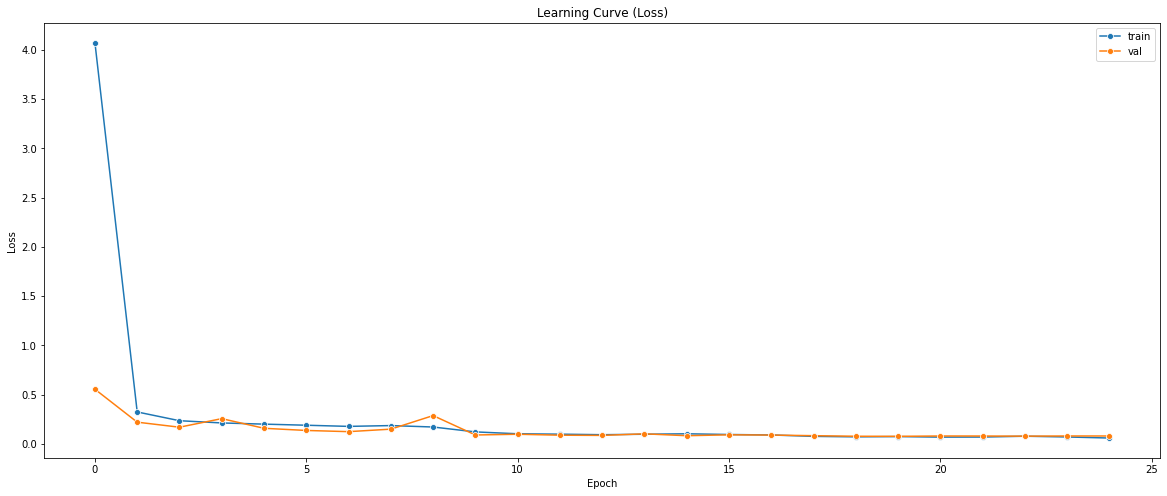

In [ ]:
# Learning Curve (Loss)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'],  marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_loss'], marker="o")
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/Learning Curve (Loss).png')
plt.show()

*   Learning Curve (Accuracy)

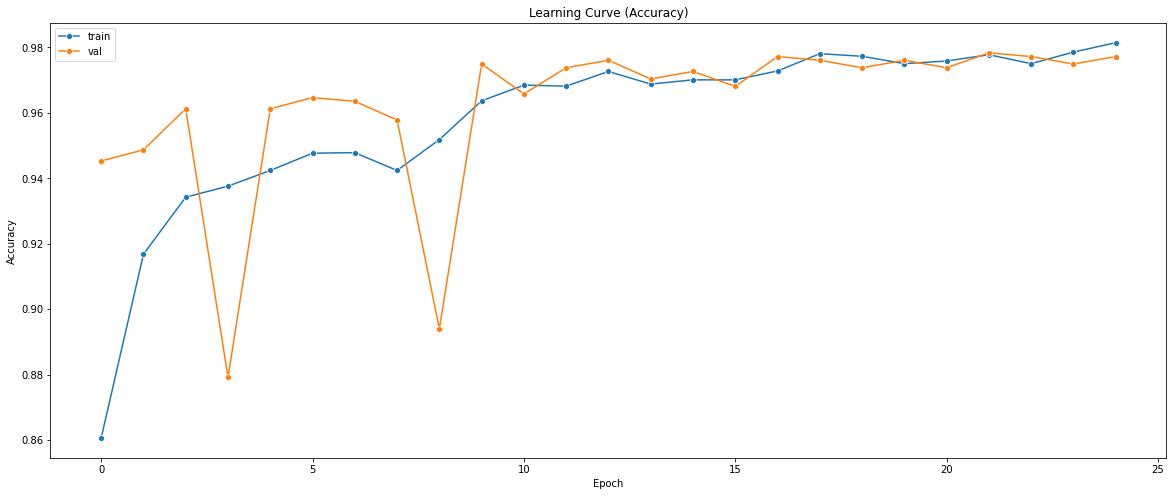

In [ ]:
# Learning Curve (Accuracy)
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['acc'],marker="o")
sns.lineplot(x = history.epoch, y = history.history['val_acc'],marker="o")
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.savefig('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/Learning Curve (Accuracy).png')
plt.show()

# **Performance Metrics**

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc

In [8]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (2 calsses chest_xray)/Model 13-03 (32% adamax)/last_epoch_model.h5')

In [9]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (2 calsses chest_xray)/Model 13-03 (32% adamax)/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 0.9824
loss: 0.0632
val_acc: 0.9863
val_loss: 0.0637
---------------------last_epoch_model-----------------------
acc: 0.9875
loss: 0.0469
val_acc: 0.9875
val_loss: 0.0659




*   Test evaluation



In [ ]:
# test evaluation
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test accuracy:'+"{:0.4f}".format(test_acc))
  print('Test loss:'+"{:0.4f}".format(test_loss))

880/880 [==============================] - 17s 19ms/step - loss: 0.0787 - acc: 0.9795
Test accuracy:0.9795
Test loss:0.0787




*   Confusion matrix



In [ ]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

880/880 [==============================] - 19s 21ms/step


In [ ]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

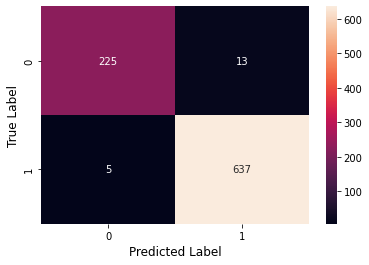

In [ ]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/confusion_matrix_res.png')
plt.show()



 

*   sensitivity & specificity




In [ ]:
def calculate_sen_spe(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    return sensitivity, specificity

In [ ]:
sensitivity, specificity = calculate_sen_spe(test_set.classes, y_pred)
print('sensitivity: '+"{:0.4f}".format(sensitivity))
print('specificity: '+"{:0.4f}".format(specificity))

sensitivity: 0.9922
specificity: 0.9454




*   precision  -  recall - f1-score - support



In [ ]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1],digits=4))

              precision    recall  f1-score   support

           0     0.9783    0.9454    0.9615       238
           1     0.9800    0.9922    0.9861       642

    accuracy                         0.9795       880
   macro avg     0.9791    0.9688    0.9738       880
weighted avg     0.9795    0.9795    0.9794       880





*  ROC Curve



ROC_AUC:  0.9963742506348333


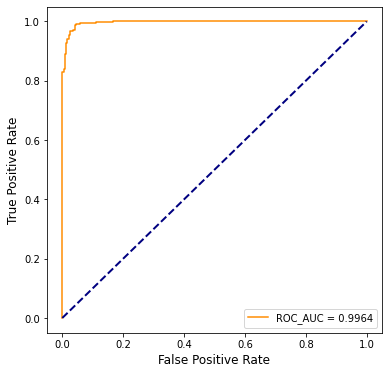

In [ ]:
# Select the second column to obtain the predicted probabilities of the positive class
# fpr -> false positive rate tpr-> true positive rate
fpr, tpr, thresholds = roc_curve(test_set.classes, Y_pred[:,1])

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)
print('ROC_AUC: ', roc_auc)

# plot the ROC curve
plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', label = 'ROC_AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/models/Model 12-03 (32% frozen adagrad)/COURBE ROC avec AUC.png')
plt.show()

# **CAM**

In [1]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib

In [10]:
# Find the last convolutional layer 
layer = model.get_layer('mobilenet_1.00_224')

In [137]:
img_ori = claheImage(cv2.imread('/content/drive/MyDrive/chest_xray 3c [AUG + NOISE] (splited .85 .075 .075)/val/Viral/person1089_virus_1808.jpeg'))/255
img = cv2.resize(img_ori, (224,224))
x =  keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
print(x.shape)
#/content/drive/MyDrive/No Aug (noise) (splited .7 .15 .15)/test/Pneumonia/person1154_bacteria_3099.jpeg

(1, 224, 224, 3)


In [138]:
preds = model.predict(x)
predicted_class = np.argmax(preds)
print(predicted_class)

1/1 [==============================] - 0s 140ms/step
1


1/1 [==============================] - 1s 1s/step


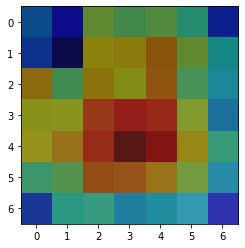

In [139]:
from google.colab.patches import cv2_imshow
new_model = tf.keras.models.Model(inputs=layer.input, outputs=[layer.get_layer('conv_pw_13').output])
# Get the final convolutional feature maps for the input image
conv_outputs = new_model.predict(x)
# Compute the class activation map
class_weights = model.layers[-1].get_weights()[0][:,predicted_class]
arr = np.ones((512,))
class_weights = np.concatenate((arr,class_weights ))
cam = np.dot(conv_outputs[0], class_weights)
cam /= np.max(cam)
# Visualize the original image and the CAM
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.show()

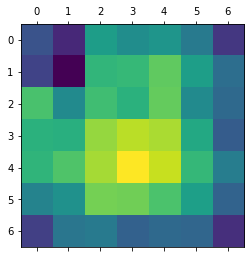

In [140]:
# Compute the class activation map
cam1 = np.dot(conv_outputs, class_weights)
res =cam1[0, :, :]
# Plot the class activation map
plt.matshow(cam1[0, :, :], cmap='viridis')
plt.show()

In [141]:
def superimpose_gradcam(img,heatmap, alpha=0.7):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = matplotlib.colormaps.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)/255
    plt.imshow(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    return superimposed_img

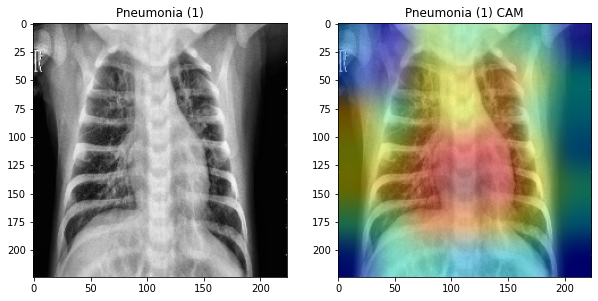

In [142]:
#plot Normal image with/without CLAHE
fig = plt.figure(figsize=(10, 10))
columns = 2 
rows = 1
fig.add_subplot(rows, columns, 1)
plt.title('Pneumonia (1)')
plt.imshow(img)

fig.add_subplot(rows, columns, 2)
plt.title('Pneumonia (1) CAM')
plt.imshow(superimpose_gradcam(img, res))
plt.show()